# Data Engineer Intern Project - By Chris Canal

### Directions:

Check out the data at http://stat-computing.org/dataexpo/2009/the-data.html. This is a large set of aviation data over a couple decades. Create an Apache Spark program that pulls in one year of data.

Create a monthly report for the top 25 busiest airports of that month. For each airport, include the following information in the report: number of flights per day at the airport, the three most common carriers at the airport for the month, average taxi time at the airport, number of weather delays per day, and the top five destinations from the airport.

Use the supplemental data to allow the report to be easier to read and understand (http://stat-computing.org/dataexpo/2009/supplemental-data.html). You can output the data as a CSV file that can be read within Excel. Be prepared to show and discuss your code.


### First Steps:
I am going to begin by importing all the libraries I am going to need for this project and initializing my spark context.

In [1]:
# First Import the needed libraries
%matplotlib inline

import numpy as np
import urllib2
import bz2
import csv
import time
import json
import os.path
from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt

import plotly.plotly as py
from plotly.graph_objs import *

from pyspark import SparkContext
sc = SparkContext('local[*]','example')  # if using locally

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

import pandas as pd

### Importing Data
This block imports data from the interent if it has not been downloaded to the local directory. 

In [2]:
# Import data from the web or from local if available

dataFiles = {'fileNames': ['flight_data_2008.csv', 'airports.csv','carriers.csv', 'plane-data.csv'],
             'fileURLs': ['http://stat-computing.org/dataexpo/2009/2008.csv.bz2',
                          'http://stat-computing.org/dataexpo/2009/airports.csv',
                          'http://stat-computing.org/dataexpo/2009/carriers.csv',
                          'http://stat-computing.org/dataexpo/2009/plane-data.csv']}

month_list = [(1, 'January'), (2, 'February'), (3, 'March'), (4, 'April'), (5, 'May'), (6, 'June'), (7, 'July'), (8, 'August'), (9, 'September'), (10, 'October'), (11, 'November'), (12, 'December')]

for i in range(len(dataFiles['fileNames'])):
    if not os.path.isfile(dataFiles['fileNames'][i]):
        print("Downloading "+dataFiles['fileNames'][i]+" from "+dataFiles['fileURLs'][i]+"...\n")
        
        start = time.time()
        response = urllib2.urlopen(dataFiles['fileURLs'][i])
        end = time.time()
        print(dataFiles['fileNames'][i]+" downloaded in "+str(end-start)+" seconds\n")
        
        print("saving "+dataFiles['fileNames'][i]+"...\n")
        start = time.time()
        data = response.read()
        
        if dataFiles['fileNames'][i][-3:] == 'csv':
            dataString = data
        elif dataFiles['fileNames'][i][-3:] == 'bz2':       
            dataString = bz2.decompress(data)
        else:
            print("Error in filetype")
        
        new_file = open(dataFiles['fileNames'][i], "w")
        new_file.write(dataString)
        new_file.close()
        end = time.time()
        print(dataFiles['fileNames'][i]+" unzipped and saved in "+str(end-start)+" seconds\n")
        
    else:
        print(dataFiles['fileNames'][i]+" has already been downloaded\n")

flight_data_2008.csv has already been downloaded

airports.csv has already been downloaded

carriers.csv has already been downloaded

plane-data.csv has already been downloaded



### Additional Data
Additional data was used from the Aircraft Registration Database. This data can be found at http://registry.faa.gov/database/ReleasableAircraft.zip

The data from the ACFTREF.txt was used. In order to run the rest of this notebook, you bust download this zip, extract the files, change the name of ACFTREF.txt to ACFTREF.csv and move that file to the local directory.

In [3]:
# Load all data into Spark DataFrames

flight_data = sc.textFile('flight_data_2008.csv')
test_flight_data = sc.textFile('flight_data_test_100.csv')
airports = sc.textFile('airports.csv')
carriers = sc.textFile('carriers.csv')
plane_data = sc.textFile('plane-data.csv')
aircraft_data = sc.textFile('ACFTREF.csv')

### Parse Functions
As you can see in the previous cell, there is a lot of data in this main data file. We don't need all of it, so we will get rid of some of that data using the filter and map functions in pyspark.

These parse functions divide the csv data into a useable format while dropping the unwanted fields.

In [4]:
def parseLineByMonth(line):
    fields = line.split(',')
    Month = int(fields[1])
    return Month
    
def parseLineByOrigin(line):
    fields = line.split(',')
    Month = int(fields[1])
    Day = int(fields[2])
    Origin = fields[16] .encode('utf8')
    Dest = fields[17].encode('utf8')
    Carrier = fields[8].encode('utf8')
    TaxIn = fields[19].encode('utf8')
    TaxOut = fields[20].encode('utf8')
    Weather = fields[25].encode('utf8')
    #TODO Add in weather
    return (Origin, (Dest, Month, Carrier, TaxIn, TaxOut, Weather, Day))

### Find busiest month
I thought it would be most adventageous to look at the busiest month in the year. The following block removes the header from the RDD and then removes all data except the month when the flight occured. The we use countByValue to count all occurences of each month. Since there are only 12 rows after in the returned python object, I will sort using pure python instead of spark. 

In [5]:
#Find busiest month in the data, this will be the
#most interesting month to analyze

header = flight_data.first() #extract header
data = flight_data.filter(lambda row: row != header)   #filter out header

rdd_month_flights = data.map(parseLineByMonth)
flights_per_month = rdd_month_flights.countByValue()

In [6]:
busiest_month = sorted(flights_per_month.items(), key=lambda t: t[1])[-1]
print("The busiest month is "+ month_list[busiest_month[0]-1][1]+" with "+str(busiest_month[1])+" flights")

The busiest month is July with 627931 flights


### Find the busiest airports
Next, I am interested in finding the 25 busiest airports. Now that we are going to be reusing some of the data when we do other calculations on these 25 airports, it is important to use the cache(  ) function in order to maximize our effeciency and minimize the ammount of work we redo. I also love using this trick where you flip the key and value in a key value pair in orde to use the sort by key function built into pyspark, so baller.

In [7]:
rdd = data.map(parseLineByOrigin) 
rdd_busy_month = rdd.filter(lambda (x,y): y[1] == busiest_month[0] ).cache()
rdd_top_25 = rdd_busy_month.flatMap(lambda x: [(x[0],1),(x[1][0],1)])
rdd_top_25 = rdd_top_25.reduceByKey(lambda x, y: x + y)
rdd_top_25 = rdd_top_25.map(lambda x: (x[1], x[0])).sortByKey()
sorted_25_airports_and_flights = rdd_top_25.collect()[-25:]

In [8]:
print("These are the top 25 busiest airports and the number of flights they had")
sorted_airports_25 = []
for i in sorted_25_airports_and_flights:
    sorted_airports_25.append(i[1])
print(sorted_25_airports_and_flights)

These are the top 25 busiest airports and the number of flights they had
[(14862, 'MDW'), (15122, 'DCA'), (16202, 'CVG'), (17224, 'SAN'), (17792, 'PHL'), (18606, 'BWI'), (21023, 'LGA'), (21184, 'BOS'), (21454, 'SEA'), (21638, 'CLT'), (23002, 'JFK'), (23156, 'MCO'), (23367, 'MSP'), (24493, 'EWR'), (24951, 'SLC'), (25687, 'SFO'), (28781, 'DTW'), (30455, 'LAS'), (33759, 'IAH'), (34780, 'PHX'), (39613, 'LAX'), (44102, 'DEN'), (50776, 'DFW'), (63171, 'ORD'), (72865, 'ATL')]


In [9]:
#create intermediate rdd with only the 25 airport data in the busy month
rdd_busy_month = rdd_busy_month.filter(lambda (x,y): (x in sorted_airports_25) or (y[0] in sorted_airports_25) ).cache()

### Main Spark Program
This part of the script can look a little intimidating. After spending a little time with the code though, it is very simple and easy to understand. Most imporant part of this block is the use of the cache( ) funciton. This function allows for an immense speed gain because spark doesn't have to recalculate costly steps with lots of data.

At a high level, this block iterates over the 25 busy airports we found earlier and exctracts a bit of data from each of them. There are a couple odd filters, you might notice. I used ".filter(lambda (x,y): y)" as a simple way to check for empty data. For some reason, there were some missing fields in the data. This filter helped me ignore those before I try to put some sort of transformation on that data. Everything else is fairly straight forward.

I store all the data that I find in a dictionary, where the airport code is the key to the data that lies within.

In [10]:
gathered_data = {}
for airport in sorted_airports_25:
    start = time.time()
    
    #cache all incoming and outgoing flights to this airport
    this_airport_rdd = rdd_busy_month.filter(lambda (x,y): (x == airport) or (y[0] == airport)).cache() 
    
    flights_per_day = this_airport_rdd.map(lambda (x,y): y[-1]).countByValue()
    
    top_3_carriers_rdd = this_airport_rdd.map(lambda (x,y): (y[2],1)).reduceByKey(lambda x,y: x+y)
    top_3_carriers = top_3_carriers_rdd.map(lambda x: (x[1], x[0])).sortByKey().collect()[-3:]
    
    landing_flights_rdd = this_airport_rdd.filter(lambda (x,y): y)
    landing_flights_rdd = landing_flights_rdd.filter(lambda (x,y): y[3] != "NA" and y[0] == airport)
    landing_flights_rdd = landing_flights_rdd.map(lambda (x,y): (1,(int(y[3]),1)))
    landing_flights_rdd = landing_flights_rdd.reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]))
    average_taxi_in = landing_flights_rdd.mapValues(lambda y: float(y[0])/y[1]).collect()

    departing_flights_rdd = this_airport_rdd.filter(lambda (x,y): y)
    departing_flights_rdd = departing_flights_rdd.filter(lambda (x,y): y[4] != "NA" and x == airport)
    departing_flights_rdd = departing_flights_rdd.map(lambda (x,y): (1,(int(y[4]),1)))
    departing_flights_rdd = departing_flights_rdd.reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]))
    average_taxi_out = departing_flights_rdd.mapValues(lambda y: float(y[0])/y[1]).collect()
    
    top_5_dest_rdd = this_airport_rdd.map(lambda (x,y): (y[0],1)).reduceByKey(lambda x,y: x+y)
    top_5_dest = top_5_dest_rdd.map(lambda x: (x[1], x[0])).sortByKey().collect()[-5:]   
    
    
    weather_delays_rdd = this_airport_rdd.filter(lambda (x,y): y)
    weather_delays_rdd = weather_delays_rdd.filter(lambda (x,y): y[5] != "NA")
    weather_delays_rdd = weather_delays_rdd.map(lambda (x,y): (y[-1],int(bool(y[5]))))
    weather_delays_per_day = weather_delays_rdd.reduceByKey(lambda x,y: x+y).sortByKey().collect()
    
    gathered_data[airport] = {"flights_per_day": dict(flights_per_day),
                              "top_3_carriers": top_3_carriers,
                              "average_taxi_in": average_taxi_in[0][1],
                              "average_taxi_out": average_taxi_out[0][1],
                              "top_5_dest": top_5_dest,
                              "weather_delays_per_day": weather_delays_per_day}
    end = time.time()
    print("Completed operations on "+airport+" in "+str(end-start)+" seconds\n")
    

Completed operations on MDW in 13.1630411148 seconds

Completed operations on DCA in 11.708468914 seconds

Completed operations on CVG in 11.4714639187 seconds

Completed operations on SAN in 11.4033751488 seconds

Completed operations on PHL in 11.6857459545 seconds

Completed operations on BWI in 11.7872509956 seconds

Completed operations on LGA in 11.7065689564 seconds

Completed operations on BOS in 11.7003757954 seconds

Completed operations on SEA in 11.4087090492 seconds

Completed operations on CLT in 11.6117489338 seconds

Completed operations on JFK in 11.6030471325 seconds

Completed operations on MCO in 11.6038050652 seconds

Completed operations on MSP in 11.7859930992 seconds

Completed operations on EWR in 11.0275211334 seconds

Completed operations on SLC in 11.3708021641 seconds

Completed operations on SFO in 11.4451708794 seconds

Completed operations on DTW in 11.5273480415 seconds

Completed operations on LAS in 11.2479250431 seconds

Completed operations on IAH i

### Now for the fun part
Spark has completed its magic, now we get to reap the reward. The following few code blocks are graphs that help us visualize the data.

In this first graph you can see that there are fewer flights on Fridays and that the 4th of this month had many fewer flights. This is probably becuase it is July in the US in this graph and the 4th is a holiday.

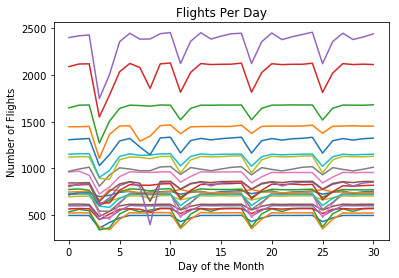

In [11]:
#View wich days of the month airlines have the most flights
for airport in sorted_airports_25:
    plt.plot(gathered_data[airport]['flights_per_day'].values())
plt.xlabel('Day of the Month')
plt.ylabel('Number of Flights')
plt.title('Flights Per Day')
plt.show()

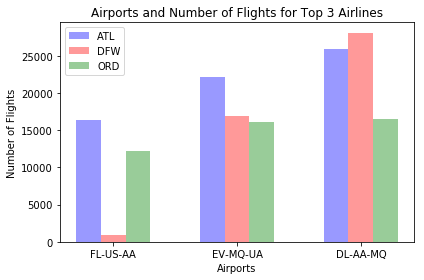

In [12]:
# bar graph of the data
ATL = gathered_data['ATL']['top_3_carriers']
DFW = gathered_data['DFW']['top_3_carriers']
ORD = gathered_data['ORD']['top_3_carriers']

n_groups = 3
std = (1,1,1)

ATL_carriers = (ATL[0][0],ATL[1][0],ATL[2][0])

DFW_carriers = (DFW[0][0],DFW[1][0],DFW[2][0])

ORD_carriers = (ORD[0][0],ORD[1][0],ORD[2][0])

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.20

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, ATL_carriers, bar_width,
                 alpha=opacity,
                 color='b',
                 yerr=std,
                 error_kw=error_config,
                 label='ATL')

rects2 = plt.bar(index + bar_width, DFW_carriers, bar_width,
                 alpha=opacity,
                 color='r',
                 yerr=std,
                 error_kw=error_config,
                 label='DFW')

rects3 = plt.bar(index + bar_width*2, ORD_carriers, bar_width,
                 alpha=opacity,
                 color='g',
                 yerr=std,
                 error_kw=error_config,
                 label='ORD')


plt.xlabel('Airports')
plt.ylabel('Number of Flights')
plt.title('Airports and Number of Flights for Top 3 Airlines')
plt.xticks(index + bar_width, ('FL-US-AA', 'EV-MQ-UA', 'DL-AA-MQ'))
plt.legend()

plt.tight_layout()
plt.show()


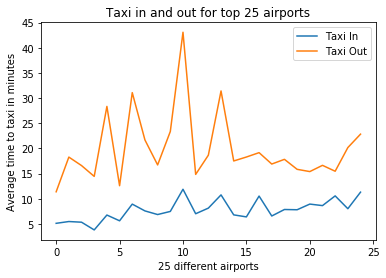

In [13]:
#View airports from least to most busy taxi time
taxi_in = []
taxi_out = []
for airport in sorted_airports_25:
    taxi_in.append(gathered_data[airport]['average_taxi_in'])
    taxi_out.append(gathered_data[airport]['average_taxi_out'])
plt.plot(taxi_in, label="Taxi In")
plt.plot(taxi_out, label="Taxi Out")
plt.xlabel('25 different airports')
plt.ylabel('Average time to taxi in minutes')
plt.title('Taxi in and out for top 25 airports')
plt.legend()
plt.show()

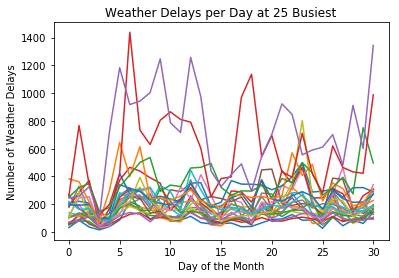

In [14]:
#View which days of the month airlines had the most weather delays
for airport in sorted_airports_25:
    weather_list = []
    for i in gathered_data[airport]['weather_delays_per_day']:
        weather_list.append(i[1])
    plt.plot(weather_list)
plt.xlabel('Day of the Month')
plt.ylabel('Number of Weather Delays')
plt.title('Weather Delays per Day at 25 Busiest')
plt.show()

In [15]:
# Display top 5 Destinations
for airport in sorted_airports_25:
    print airport, gathered_data[airport]['top_5_dest']

MDW [(315, 'LAS'), (317, 'STL'), (321, 'MCI'), (396, 'DEN'), (7431, 'MDW')]
DCA [(636, 'ATL'), (636, 'ORD'), (756, 'BOS'), (1000, 'LGA'), (7561, 'DCA')]
CVG [(292, 'DFW'), (293, 'DTW'), (329, 'LGA'), (508, 'ORD'), (8105, 'CVG')]
SAN [(484, 'LAS'), (620, 'SFO'), (663, 'PHX'), (999, 'LAX'), (8613, 'SAN')]
PHL [(577, 'BOS'), (597, 'ORD'), (617, 'MCO'), (623, 'ATL'), (8896, 'PHL')]
BWI [(340, 'PVD'), (411, 'MCO'), (446, 'BOS'), (537, 'ATL'), (9303, 'BWI')]
LGA [(930, 'ATL'), (935, 'ORD'), (996, 'DCA'), (1080, 'BOS'), (10506, 'LGA')]
BOS [(652, 'ORD'), (729, 'JFK'), (760, 'DCA'), (1079, 'LGA'), (10591, 'BOS')]
SEA [(531, 'SFO'), (612, 'DEN'), (678, 'ANC'), (686, 'LAX'), (10728, 'SEA')]
CLT [(477, 'ORD'), (504, 'LGA'), (517, 'ATL'), (525, 'EWR'), (10821, 'CLT')]
JFK [(478, 'MCO'), (607, 'SFO'), (737, 'LAX'), (745, 'BOS'), (11499, 'JFK')]
MCO [(412, 'EWR'), (477, 'JFK'), (618, 'PHL'), (802, 'ATL'), (11578, 'MCO')]
MSP [(484, 'DEN'), (490, 'DTW'), (514, 'ATL'), (866, 'ORD'), (11684, 'MSP')]
EW

In [16]:
with open('output.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in gathered_data.items():
       writer.writerow([key, value])
    
with open('output.json', 'w') as fp:
    json.dump(gathered_data, fp)

In [19]:
a = range(6)
print(a)
print(a[:-1])

[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4]
